# Jago:

## Import packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk 
import warnings
import gensim
import re
import datetime
import collections
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.snowball import ItalianStemmer
from gensim.corpora import Dictionary
warnings.filterwarnings('ignore')

## Load dataset:

In [2]:
trains24 = pd.read_csv("./Dataset/articoliS24O.csv", delimiter="\t")
trainRadiocor = pd.read_csv("./Dataset/articoliRadiocor.csv", delimiter='\t')

In [3]:
colsel_trains24 = trains24[['identificativo', 'body']]
colsel_trains24.head()

,identificativo,body
0,FM20160429032ACC9MUHD,Acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"L’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,Si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,Un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,A volte le provocazioni sortiscono l’effetto s...


In [4]:
colsel_trainRadiocor = trainRadiocor[['identificativo', 'body']]
colsel_trainRadiocor.head()

,identificativo,body
0,RR201611141524426,L'obiettivo e' raccolta fondi per supporto a f...
1,RR201611141638439,L'obiettivo e' raccolta fondi per supporto a f...
2,RR201611141655450,"(Il Sole 24 Ore Radiocor Plus) - Milano, 14 no..."
3,RR201611101529490,"(Il Sole 24 Ore Radiocor Plus) - Milano, 10 no..."
4,RR201611101517481,"(Il Sole 24 Ore Radiocor Plus) - Milano, 10 no..."


In [5]:
colsel_merged = pd.concat([colsel_trains24, colsel_trainRadiocor])
colsel_merged.shape

(10181, 2)

In [6]:
colsel_merged.dropna(inplace=True)
colsel_merged = colsel_merged.reset_index()
colsel_merged = colsel_merged.drop('index', axis=1)

In [7]:
colsel_merged.head()

,identificativo,body
0,FM20160429032ACC9MUHD,Acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"L’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,Si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,Un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,A volte le provocazioni sortiscono l’effetto s...


## Clean dataset:

In [8]:
colsel_merged['body'] = colsel_merged['body'].apply(lambda x : str(x).lower())
colsel_merged['body'] = colsel_merged['body'].str.replace(r'( )+',' ')
colsel_merged['body'] = colsel_merged['body'].str.replace('\n','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'il( )?sole( )?24( )?ore','sole24ore')
colsel_merged['body'] = colsel_merged['body'].str.replace('(milion(i|e)|miliard(i|o)|euro)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((\()?( )?sole24ore (radiocor)?( plus)?( )?(\))?.\-.*?)\-','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(continua (da )?pagina [0-9]+)© riproduzione riservata(continua (da )?pagina [0-9]+)', '')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((© )?riproduzione riser(vata)?).*','') 
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(www\.|http\:\/\/|https\:\/\/|\.com|\.net|\.org|\.it|@[a-zA-Z]+)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','')  
print("SHAPE BEFORE REMOVING DUPLICATES: " + str(colsel_merged.shape)) 
colsel_merged.drop_duplicates(inplace=True) 
print("SHAPE AFTER REMOVING DUPLICATES: " + str(colsel_merged.shape)) 
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: BeautifulSoup(str(x), "lxml").get_text())

SHAPE BEFORE REMOVING DUPLICATES: (10150, 2)
SHAPE AFTER REMOVING DUPLICATES: (9283, 2)


In [9]:
def tagDocuments(text):
    for i, line in enumerate(text):
        if(i%1000 == 0):
            print("> Iteration: " + str(i))
        yield gensim.models.doc2vec.TaggedDocument([w for w in gensim.utils.simple_preprocess(line)], [i])

In [10]:
colsel_merged = colsel_merged.reset_index()
colsel_merged = colsel_merged.drop('index', axis=1)
colsel_merged.head()

,identificativo,body
0,FM20160429032ACC9MUHD,acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"l’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,a volte le provocazioni sortiscono l’effetto s...


## Extract train data from dataframe into list:

In [11]:
print("> START %s" % datetime.datetime.now())
train_corpus = list(tagDocuments(colsel_merged['body'].tolist()))
print("> END %s" % str(datetime.datetime.now()))

len(train_corpus)

> START 2017-03-17 18:52:17.272464
> Iteration: 0
> Iteration: 1000
> Iteration: 2000
> Iteration: 3000
> Iteration: 4000
> Iteration: 5000
> Iteration: 6000
> Iteration: 7000
> Iteration: 8000
> Iteration: 9000
> END 2017-03-17 18:52:22.342050


9283

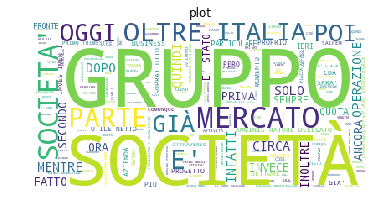

In [12]:
def wordcloud(dataframe):
    wordcloud = WordCloud(background_color="white", stopwords = stopwords.words("italian")).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7
    plt.figure
    plt.axis("off")
    plt.title("plot")
    plt.show()

wc = wordcloud(colsel_merged['body'])

# New section:

In [13]:
list_of_corpus = []

for i in np.arange(0, len(train_corpus)):
    
    list_of_corpus.append(train_corpus[i][0])

stops = set(stopwords.words('italian'))

In [14]:
bigram = gensim.models.Phrases(list_of_corpus)

In [15]:
def process_texts(documents):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    #no stop words
    texts = [[word for word in document if word not in stops] for document in documents]
    
    #bigram aggregation
    texts = [bigram[document] for document in documents]
    
    #from nltk.stem import WordNetLemmatizer
    #lemmatizer = WordNetLemmatizer()
    
    #texts = [[word for word in lemmatizer.lemmatize(' '.join(document), pos='v').split()] for document in documents]

    return texts

In [16]:
train_texts = process_texts(list_of_corpus)

second_dictionary = Dictionary(train_texts)
corpus = [second_dictionary.doc2bow(text) for text in train_texts]

In [17]:
corpus[0][0]

(0, 1)